In [377]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from lifelines import KaplanMeierFitter, CoxPHFitter
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.feature_selection import chi2


In [3]:
# Upload data
heart_failure = pd.read_csv("~/Downloads/heart_failure_clinical_records_dataset.csv")

In [265]:
heart_failure.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [268]:
# convert to categorical values in heart failure columns
heart_failure["anaemia"] = heart_failure["anaemia"].astype('category')
heart_failure["high_blood_pressure"] = heart_failure["high_blood_pressure"].astype('category')
heart_failure["DEATH_EVENT"] = heart_failure["DEATH_EVENT"].astype('category')
heart_failure.dtypes

age                          float64
anaemia                     category
creatinine_phosphokinase       int64
diabetes                    category
ejection_fraction              int64
high_blood_pressure         category
platelets                    float64
serum_creatinine             float64
serum_sodium                   int64
sex                         category
smoking                     category
time                           int64
DEATH_EVENT                 category
dtype: object

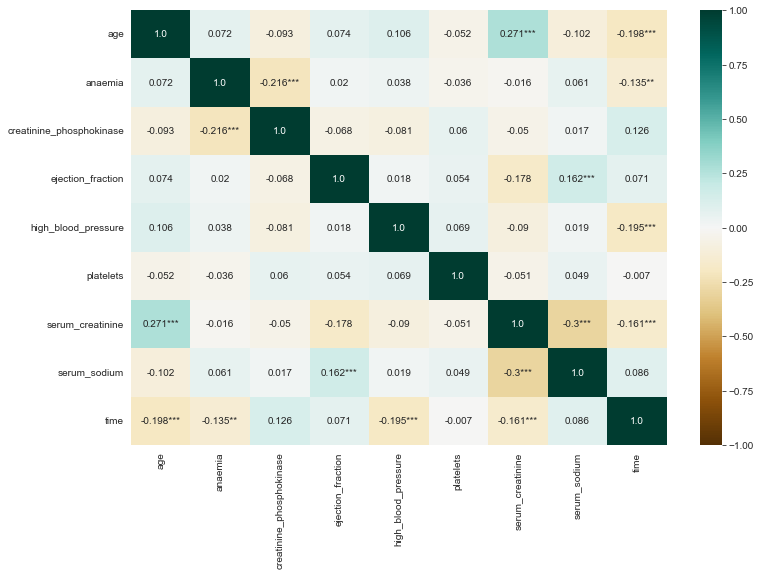

In [236]:
# 1. Create a linear regression for the “time” variable. Exclude the variable “DEATH_EVENT” from the analysis.
# 1.a. Check if there is any correlation between the independent variables (X’s).
rho = heart_failure.loc[:,heart_failure.columns != "DEATH_EVENT"].corr(method= 'spearman')
p_val = heart_failure.loc[:,heart_failure.columns != "DEATH_EVENT"].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = p_val.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if (x <= t and x != 0)]))
labels = rho.round(3).astype(str) + p


plt.figure(figsize=(12,8))
# sns.heatmap(heart_failure.loc[:,heart_failure.columns != "DEATH_EVENT"].corr(), cmap='coolwarm', annot= True, vmin=-1)
sns.heatmap(rho, cmap='BrBG', annot= labels, vmin=-1, fmt="")
plt.show()

In [398]:
list_cat = heart_failure.select_dtypes(include=['category']).columns
list_cat = list(list_cat)
heart_failure_cat = heart_failure.loc[:,list_cat]
heart_failure_cat = heart_failure_cat.loc[:,heart_failure_cat.columns != "DEATH_EVENT"]

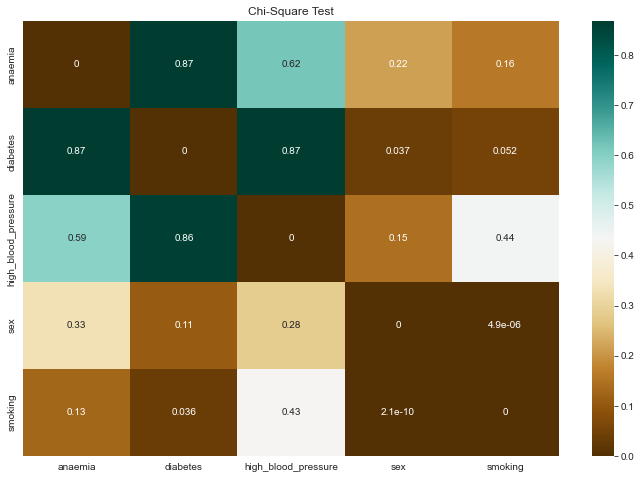

In [437]:
resultant = pd.DataFrame(data=[(0 for i in range(len(heart_failure_cat.columns))) for i in range(len(heart_failure_cat.columns))],
                         columns=list(heart_failure_cat.columns))
resultant.set_index(pd.Index(list(heart_failure_cat.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(heart_failure_cat.columns):
    for j in list(heart_failure_cat.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(heart_failure_cat[i]).reshape(-1, 1), np.array(heart_failure_cat[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val

fig = plt.figure(figsize=(12,8))
sns.heatmap(resultant, annot=True, cmap='BrBG')
plt.title('Chi-Square Test')
plt.show()

In [421]:
# 1.b. Check if the betas for the model are inflated (use the VIF function).
df = heart_failure.loc[:,heart_failure.columns != "DEATH_EVENT"]

def vif(df):
    '''
    VIF = variance inflation function
    '''
    import pandas as pd
    # initialize dictionaries
    vif_dict = {}
    # X must be a dataframe and contain the independent variables only
    for var in df.columns:
        indep = [i for i in df.columns if i != var]
        X, y = df[indep], df[var]

        # extract r-squared from the fit
        #rsqr = LinearRegression().fit(X, y).score(X, y)
        model = sm.OLS(y,X).fit()
        rsqr = model.rsquared
        # calculate VIF
        vif = 1/(1 - rsqr)
        vif_dict[var] = vif

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict})
    # return df_vif

    df_vif_3 = df_vif[df_vif['VIF'] <= 3] # drop columns VIF < 3
    return df_vif_3
vif(df)

,VIF
anaemia,1.909994
creatinine_phosphokinase,1.448473
diabetes,1.789419
high_blood_pressure,1.646044
serum_creatinine,2.919913
smoking,1.892753


                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.560
Method:                 Least Squares   F-statistic:                              64.48
Date:                Mon, 12 Sep 2022   Prob (F-statistic):                    9.96e-51
Time:                        11:51:34   Log-Likelihood:                         -1799.7
No. Observations:                 299   AIC:                                      3611.
Df Residuals:                     293   BIC:                                      3634.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

<AxesSubplot:ylabel='time'>

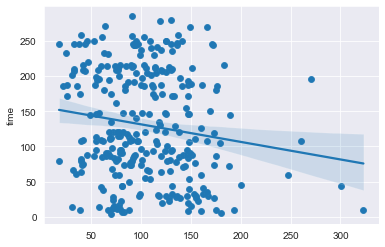

In [422]:
# 1.c. Recreate the linear regression excluding problematic variables, if they exist.
df_vif_3 = vif(df).T

heart_failure_VIF = heart_failure.loc[:,df_vif_3.columns]

X = heart_failure_VIF
Y = heart_failure["time"]

model = sm.OLS(Y,X)
mod1 = model.fit()
print(mod1.summary())
pred1 = mod1.predict(X)
sns.scatterplot(x=pred1,y=Y)
# sns.scatterplot(x=Y,y=pred1)
sns.regplot(x=pred1,y=Y)
# sns.regplot(x=Y,y=pred1)
# sns.distplot(pred1)


In [243]:
# 1.d. Calculate the exponential (exp) of the estimates, and based on the p-value determine which values increase the risk (Relative Risk).
RR = np.exp(mod1.params)
RR

anaemia                     2.565757e+14
creatinine_phosphokinase    1.019773e+00
diabetes                    9.106342e+25
high_blood_pressure         4.695658e+05
serum_creatinine            2.480672e+10
smoking                     2.682329e+21
dtype: float64

In [138]:
# 2. Create a logistic regression model for the “DEATH_EVENT” variable. Exclude the “time” variable from the analysis.
# 2.a. Check if the betas for the model are inflated (use the VIF function).
heart_failure_E = heart_failure.loc[:,heart_failure.columns != "time"]
heart_failure_E3 = vif(heart_failure_E).T
heart_failure_E3

,DEATH_EVENT,anaemia,creatinine_phosphokinase,diabetes,high_blood_pressure,smoking
VIF,1.904495,1.879885,1.458051,1.791558,1.594384,1.890089


                 Generalized Linear Model Regression Results                  
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                            GLM   Df Residuals:                      293
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -185.16
Date:                Mon, 05 Sep 2022   Deviance:                       370.33
Time:                        14:33:36   Pearson chi2:                     299.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01665
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/Users/odedsabah/PycharmProjects/DS - 14/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,DEATH_EVENT,anaemia,creatinine_phosphokinase,diabetes,high_blood_pressure,smoking
0,1,0,582,0,1,0
1,1,0,7861,0,0,0
2,1,0,146,0,0,1
3,1,1,111,0,0,0
4,1,1,160,1,0,0


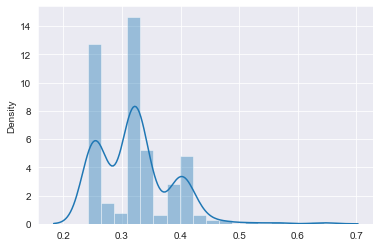

In [201]:
# 2.b. Recreate the linear regression excluding problematic variables, if they exist.
heart_failure_VIF = heart_failure.loc[:,heart_failure_E3.columns]
formula = 'DEATH_EVENT ~ anaemia + creatinine_phosphokinase + diabetes + high_blood_pressure + smoking'
model = smf.glm(formula = formula, data=heart_failure_VIF, family=sm.families.Binomial())
mod2 = model.fit()
print(mod2.summary())
pred2 = mod2.predict(heart_failure_VIF)
sns.distplot(pred2)


In [141]:
# 2.c. Calculate the exponential of the estimates, and based on the p-value determine which values increase the probability of death (Odds Ratios).
OR=np.exp(mod2.params)
OR

Intercept                   0.318001
anaemia                     1.411761
creatinine_phosphokinase    1.000177
diabetes                    1.006795
high_blood_pressure         1.443695
smoking                     1.001835
dtype: float64

In [171]:
# 3. Calculate the Kaplan-Meyer curve for the survival time, using the “time” and “DEATH_EVENT” variables.
# 3.a. Check if there is any difference between males and females.
heart_failure['sex'] = heart_failure['sex'].astype('category')
groups = heart_failure['sex']
i1 = (groups == '0')  ## males
i2 = (groups == '1') ## females

kmf1 = KaplanMeierFitter()
kmf1.fit(heart_failure['time'][heart_failure['sex'] == 0], heart_failure['DEATH_EVENT'][heart_failure['sex'] == 0], label='Male')

<lifelines.KaplanMeierFitter:"Male", fitted with 105 total observations, 71 right-censored observations>

In [170]:
kmf2 = KaplanMeierFitter()
kmf2.fit(heart_failure['time'][heart_failure['sex'] == 1], heart_failure['DEATH_EVENT'][heart_failure['sex'] == 1], label='Female')

<lifelines.KaplanMeierFitter:"Female", fitted with 194 total observations, 132 right-censored observations>

<AxesSubplot:xlabel='timeline'>

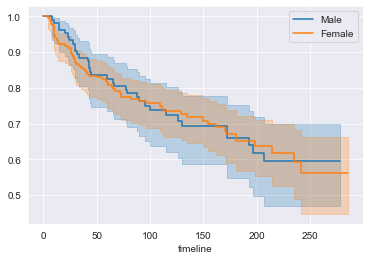

In [172]:
a1 = kmf1.plot()
kmf2.plot(ax=a1)

In [175]:
# 3.b. Check if there is any difference between smokers and non-smokers.
heart_failure['smoking'] = heart_failure['smoking'].astype('category')
groups = heart_failure['smoking']
i1 = (groups == '0')  ## smokers
i2 = (groups == '1') ## non-smokers

kmf1 = KaplanMeierFitter()
kmf1.fit(heart_failure['time'][heart_failure['smoking'] == 0], heart_failure['DEATH_EVENT'][heart_failure['smoking'] == 0], label='smokers')

<lifelines.KaplanMeierFitter:"smokers", fitted with 203 total observations, 137 right-censored observations>

In [176]:
kmf2 = KaplanMeierFitter()
kmf2.fit(heart_failure['time'][heart_failure['smoking'] == 1], heart_failure['DEATH_EVENT'][heart_failure['smoking'] == 1], label='non-smokers')

<lifelines.KaplanMeierFitter:"non-smokers", fitted with 96 total observations, 66 right-censored observations>

<AxesSubplot:xlabel='timeline'>

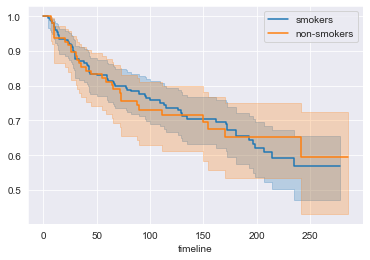

In [177]:
a1 = kmf1.plot()
kmf2.plot(ax=a1)

In [178]:
# 3.c. Check if there is any difference between diabetics and non-diabetics.
heart_failure['diabetes'] = heart_failure['diabetes'].astype('category')
groups = heart_failure['diabetes']
i1 = (groups == '0')  ## non-diabetics
i2 = (groups == '1') ## diabetics

kmf1 = KaplanMeierFitter()
kmf1.fit(heart_failure['time'][heart_failure['diabetes'] == 0], heart_failure['DEATH_EVENT'][heart_failure['diabetes'] == 0], label='non-diabetics')

<lifelines.KaplanMeierFitter:"non-diabetics", fitted with 174 total observations, 118 right-censored observations>

In [179]:
kmf2 = KaplanMeierFitter()
kmf2.fit(heart_failure['time'][heart_failure['diabetes'] == 1], heart_failure['DEATH_EVENT'][heart_failure['diabetes'] == 1], label='diabetics')

<lifelines.KaplanMeierFitter:"diabetics", fitted with 125 total observations, 85 right-censored observations>

<AxesSubplot:xlabel='timeline'>

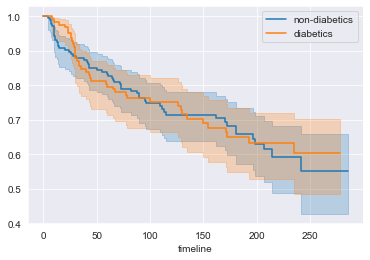

In [180]:
a1 = kmf1.plot()
kmf2.plot(ax=a1)

In [423]:
# 4. Create a Cox regression using the “time” and “DEATH_EVENT” as the outcome and the other variables as the independent predictors (X’s).
# 4.a. Check if the betas for the model are inflated (use the VIF function).
heart_failure_cox = vif(heart_failure).T
heart_failure_cox = heart_failure.loc[:,heart_failure_cox.columns]
heart_failure_cox['time'] = heart_failure['time'].values
heart_failure_cox

,DEATH_EVENT,anaemia,creatinine_phosphokinase,diabetes,high_blood_pressure,smoking,time
0,1,0,582,0,1,0,4
1,1,0,7861,0,0,0,6
2,1,0,146,0,0,1,7
3,1,1,111,0,0,0,7
4,1,1,160,1,0,0,8
...,...,...,...,...,...,...,...
294,0,0,61,1,1,1,270
295,0,0,1820,0,0,0,271
296,0,0,2060,1,0,0,278
297,0,0,2413,0,0,1,280


/Users/odedsabah/PycharmProjects/DS - 14/venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'category' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<AxesSubplot:xlabel='log(HR) (95% CI)'>

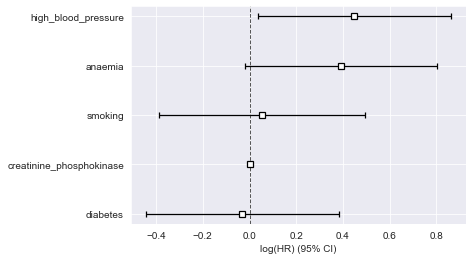

In [439]:
# 4.b. Recreate the Cox regression excluding problematic variables, if they exist.
cph = CoxPHFitter()
cph.fit(heart_failure_cox,duration_col='time', event_col='DEATH_EVENT')
cph.plot()


/Users/odedsabah/PycharmProjects/DS - 14/venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'category' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<AxesSubplot:xlabel='log(HR) (95% CI)'>

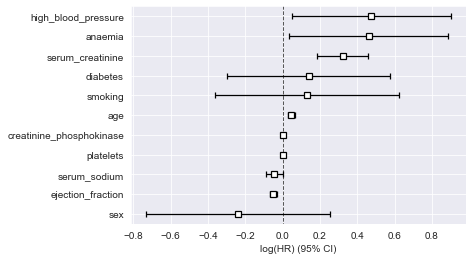

In [440]:
cph = CoxPHFitter()
cph.fit(heart_failure, duration_col='time', event_col='DEATH_EVENT')
cph.plot()